# 02 — CDC PLACES Health Modeling (County Level)

**Goal:** Evaluate associations between long-term PM₂.₅ exposure and county-level asthma prevalence using CDC PLACES data.

This notebook supports two modes:
- `SCOPE = "dmv"` → Regional analysis (small-n)
- `SCOPE = "us"` → National analysis (large-n)

We fit interpretable baseline OLS models and quantify uncertainty.


In [19]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

pd.set_option("display.max_columns", 200)

# --- Configuration ---
SCOPE = "us"  # change to "us" for nationwide analysis

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_RAW = os.path.join(PROJECT_ROOT, "data", "raw")
DATA_PROCESSED = os.path.join(PROJECT_ROOT, "data", "processed")
FIGURES = os.path.join(PROJECT_ROOT, "figures")

os.makedirs(FIGURES, exist_ok=True)

print("Scope:", SCOPE)
print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_RAW:", DATA_RAW)
print("DATA_PROCESSED:", DATA_PROCESSED)
print("FIGURES:", FIGURES)


Scope: us
PROJECT_ROOT: /Users/aishwaryaiyer/Documents/GitHub/project-air-health
DATA_RAW: /Users/aishwaryaiyer/Documents/GitHub/project-air-health/data/raw
DATA_PROCESSED: /Users/aishwaryaiyer/Documents/GitHub/project-air-health/data/processed
FIGURES: /Users/aishwaryaiyer/Documents/GitHub/project-air-health/figures


In [21]:
# --- Load CDC PLACES county data ---
PLACES_PATH = os.path.join(DATA_RAW, "cdc_places_county.csv")
places = pd.read_csv(PLACES_PATH, low_memory=False)

print("PLACES shape:", places.shape)
print("Columns (first 30):", list(places.columns)[:30])

# --- Identify county GEOID column and standardize to 5-digit string ---
geoid_candidates = ["CountyFIPS", "LocationID", "GEOID", "County_FIPS"]
geoid_col = next((c for c in geoid_candidates if c in places.columns), None)

if geoid_col is None:
    raise ValueError("No county GEOID column found in PLACES file.")

print("Using GEOID column:", geoid_col)

# Standardize: always 5-digit string
places[geoid_col] = places[geoid_col].astype(str).str.replace(r"\.0$", "", regex=True).str.zfill(5)

# Quick look at outcomes related to respiratory / cardiovascular health
outcome_cols = [c for c in places.columns if any(
    k in c.lower() for k in ["asthma", "copd", "heart", "resp"]
)]

print("Candidate outcome columns:")
for c in outcome_cols[:20]:
    print(" -", c)


PLACES shape: (229298, 22)
Columns (first 30): ['Year', 'StateAbbr', 'StateDesc', 'LocationName', 'DataSource', 'Category', 'Measure', 'Data_Value_Unit', 'Data_Value_Type', 'Data_Value', 'Data_Value_Footnote_Symbol', 'Data_Value_Footnote', 'Low_Confidence_Limit', 'High_Confidence_Limit', 'TotalPopulation', 'TotalPop18plus', 'LocationID', 'CategoryID', 'MeasureId', 'DataValueTypeID', 'Short_Question_Text', 'Geolocation']
Using GEOID column: LocationID
Candidate outcome columns:


In [23]:
# --- Select asthma outcome (adult current asthma prevalence) ---

# --- Inspect asthma-related measures (sanity check) ---
asthma_measures = places[places["Measure"].astype(str).str.contains("asthma", case=False, na=False)]
asthma_measures["Measure"].value_counts().head(10)



Measure
Current asthma among adults    5916
Name: count, dtype: int64

In [25]:
# --- Select adult asthma outcome (crude prevalence) ---
ASTHMA_MEASURE = "Current asthma among adults"

asthma = places[
    (places["Measure"] == ASTHMA_MEASURE) &
    (places["Data_Value_Type"].astype(str).str.contains("Crude", case=False, na=False))
].copy()

# Keep needed columns (handle cases where CI column names differ)
keep_cols = [geoid_col, "Year", "Data_Value", "TotalPopulation"]
ci_low = "Low_Confidence_Limit" if "Low_Confidence_Limit" in asthma.columns else None
ci_high = "High_Confidence_Limit" if "High_Confidence_Limit" in asthma.columns else None
if ci_low: keep_cols.append(ci_low)
if ci_high: keep_cols.append(ci_high)

asthma = asthma[keep_cols].copy()

# Rename
rename_map = {
    geoid_col: "geoid",
    "Data_Value": "asthma_prev",
    "TotalPopulation": "TotalPopulation"
}
if ci_low: rename_map[ci_low] = "asthma_ci_low"
if ci_high: rename_map[ci_high] = "asthma_ci_high"

asthma = asthma.rename(columns=rename_map)

# Standardize geoid
asthma["geoid"] = asthma["geoid"].astype(str).str.replace(r"\.0$", "", regex=True).str.zfill(5)

print("Asthma table:", asthma.shape)
print("Years in asthma:", sorted(asthma["Year"].unique())[:10], "...", sorted(asthma["Year"].unique())[-10:])
asthma.head()


Asthma table: (2958, 6)
Years in asthma: [2023] ... [2023]


,geoid,Year,asthma_prev,TotalPopulation,asthma_ci_low,asthma_ci_high
1,05049,2023,10.6,"12,421",9.2,11.9
9,08065,2023,10.2,"7,365",9.0,11.6
64,23009,2023,12.1,"56,526",10.7,13.5
66,24013,2023,10.1,"176,639",8.9,11.4
83,31171,2023,9.0,677,7.9,10.1


In [27]:
# --- Load PM2.5 county×month table from Notebook 01 ---
pm_filename = f"pm25_county_monthly_{SCOPE}.csv"
PM25_PATH = os.path.join(DATA_PROCESSED, pm_filename)

pm25_cm = pd.read_csv(PM25_PATH, low_memory=False)

pm25_cm["geoid"] = pm25_cm["geoid"].astype(str).str.replace(r"\.0$", "", regex=True).str.zfill(5)
pm25_cm["month"] = pd.to_datetime(pm25_cm["month"], errors="coerce")
pm25_cm = pm25_cm.dropna(subset=["month", "geoid"])

pm25_cm["year"] = pm25_cm["month"].dt.year

print("Loaded PM2.5:", pm25_cm.shape)
pm25_cm.head()


Loaded PM2.5: (14853, 6)


,geoid,month,pm25_median,pm25_mean,n_obs,year
0,01003,2018-01-01,5.75,6.34,10,2018
1,01003,2018-02-01,5.30,5.53,10,2018
2,01003,2018-03-01,8.00,7.48,10,2018
3,01003,2018-04-01,6.85,7.12,10,2018
4,01003,2018-05-01,8.20,8.13,10,2018


In [29]:
# --- Build long-term exposure (align with PLACES 2023) ---
pm25_for_health = pm25_cm[pm25_cm["year"] <= 2023].copy()

pm25_exposure = (
    pm25_for_health
    .groupby("geoid")
    .agg(
        pm25_mean_long=("pm25_mean", "mean"),
        pm25_median_long=("pm25_median", "mean"),
        n_months=("pm25_mean", "size"),
    )
    .reset_index()
)

print("Exposure table:", pm25_exposure.shape)
pm25_exposure.head()


Exposure table: (642, 4)


,geoid,pm25_mean_long,pm25_median_long,n_months
0,01003,7.289322,6.997917,24
1,01027,7.140384,6.885417,24
2,01033,7.456928,6.892500,20
3,01049,7.237250,6.993750,24
4,01055,8.043748,7.666667,24


In [31]:
# --- Align to a single PLACES year (default 2023) and merge ---
TARGET_YEAR = 2023
if TARGET_YEAR not in set(asthma["Year"].unique()):
    TARGET_YEAR = int(max(asthma["Year"].unique()))
print("Using PLACES year:", TARGET_YEAR)

asthma_y = asthma[asthma["Year"] == TARGET_YEAR].copy()

# Merge on geoid
model_df = asthma_y.merge(pm25_exposure, on="geoid", how="inner")

print("Modeling table:", model_df.shape)
model_df.head()

print("Geoids in asthma year:", asthma_y["geoid"].nunique())
print("Geoids in pm25 exposure:", pm25_exposure["geoid"].nunique())
print("Geoids after merge:", model_df["geoid"].nunique())

model_df.describe()


Using PLACES year: 2023
Modeling table: (581, 9)
Geoids in asthma year: 2958
Geoids in pm25 exposure: 642
Geoids after merge: 581


,Year,asthma_prev,asthma_ci_low,asthma_ci_high,pm25_mean_long,pm25_median_long,n_months
count,581.0,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000
mean,2023.0,10.564372,9.330120,11.899656,7.436141,6.769341,23.302926
std,0.0,0.955612,0.862537,1.062950,1.825726,1.689366,3.037889
min,2023.0,7.900000,7.000000,9.000000,1.728065,1.567708,1.000000
25%,2023.0,9.900000,8.800000,11.200000,6.390513,5.771065,24.000000
50%,2023.0,10.600000,9.300000,11.900000,7.539675,6.951782,24.000000
75%,2023.0,11.200000,9.900000,12.600000,8.478001,7.825000,24.000000
max,2023.0,14.300000,12.900000,16.100000,15.035198,13.277344,24.000000


In [33]:
# --- OLS baseline (robust SE) ---
model_df = model_df.copy()

# Ensure numeric types
model_df["asthma_prev"] = pd.to_numeric(model_df["asthma_prev"], errors="coerce")
model_df["pm25_mean_long"] = pd.to_numeric(model_df["pm25_mean_long"], errors="coerce")

# TotalPopulation sometimes comes in as strings with commas; clean + convert
model_df["TotalPopulation"] = (
    model_df["TotalPopulation"]
    .astype(str)
    .str.replace(",", "", regex=False)
)
model_df["TotalPopulation"] = pd.to_numeric(model_df["TotalPopulation"], errors="coerce")

# Drop rows with missing essentials
model_df = model_df.dropna(subset=["asthma_prev", "pm25_mean_long", "TotalPopulation"]).copy()

# log(pop)
model_df["log_pop"] = np.log(model_df["TotalPopulation"].clip(lower=1))

# Fit
X = model_df[["pm25_mean_long", "log_pop"]]
X = sm.add_constant(X)
y = model_df["asthma_prev"]

ols = sm.OLS(y, X).fit(cov_type="HC3")
print(ols.summary())


                            OLS Regression Results                            
Dep. Variable:            asthma_prev   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     19.75
Date:                Mon, 16 Feb 2026   Prob (F-statistic):           5.06e-09
Time:                        15:10:10   Log-Likelihood:                -774.46
No. Observations:                 581   AIC:                             1555.
Df Residuals:                     578   BIC:                             1568.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             12.6546      0.362     34.

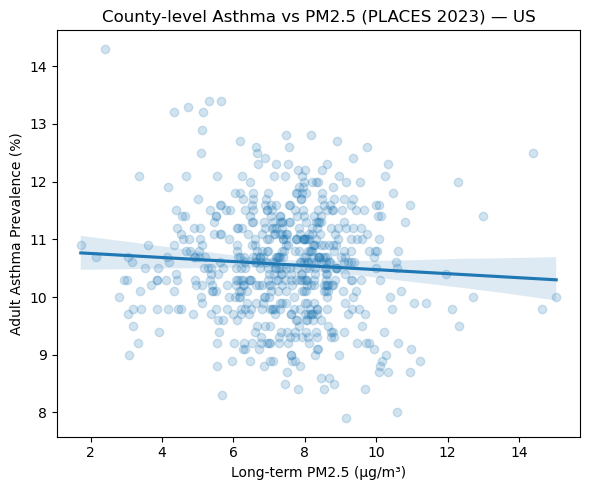

In [35]:
plt.figure(figsize=(6, 5))

sns.regplot(
    x="pm25_mean_long",
    y="asthma_prev",
    data=model_df,
    ci=95,
    scatter_kws={"alpha": 0.2} if SCOPE == "us" else {"alpha": 0.9}
)

plt.xlabel("Long-term PM2.5 (µg/m³)")
plt.ylabel("Adult Asthma Prevalence (%)")
plt.title(f"County-level Asthma vs PM2.5 (PLACES {TARGET_YEAR}) — {SCOPE.upper()}")
plt.tight_layout()
plt.show()


In [17]:
# --- Save modeling table + figure ---
out_csv = os.path.join(DATA_PROCESSED, f"modeling_table_places_pm25_{SCOPE}.csv")
model_df.to_csv(out_csv, index=False)
print("Saved:", out_csv)

fig_path = os.path.join(FIGURES, f"asthma_vs_pm25_{SCOPE}.png")
plt.figure(figsize=(6, 5))
sns.regplot(
    x="pm25_mean_long",
    y="asthma_prev",
    data=model_df,
    ci=95,
    scatter_kws={"alpha": 0.2} if SCOPE == "us" else {"alpha": 0.9}
)
plt.xlabel("Long-term PM2.5 (µg/m³)")
plt.ylabel("Adult Asthma Prevalence (%)")
plt.title(f"County-level Asthma vs PM2.5 (PLACES {TARGET_YEAR}) — {SCOPE.upper()}")
plt.tight_layout()
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
plt.close()
print("Saved:", fig_path)


Saved: /Users/aishwaryaiyer/Documents/GitHub/project-air-health/data/processed/modeling_table_places_pm25_dmv.csv
Saved: /Users/aishwaryaiyer/Documents/GitHub/project-air-health/figures/asthma_vs_pm25_dmv.png
